In [1]:
import cv2
import pandas as pd
import numpy as np
import time
#from google.colab.patches import cv2_imshow
from collections import Counter
from keras.preprocessing import image
from matplotlib import pyplot
from PIL import Image
import glob
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split


In [2]:
#Load YOLO

net = cv2.dnn.readNet("yolov3-tiny.weights","yolov3-tiny.cfg") #Tiny Yolo
classes = []
with open("coco_classes.txt","r") as f:
    classes = [line.strip() for line in f.readlines()]

print(classes)



['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [3]:
model_classifier = tf.keras.models.load_model('class_model_updated')

In [4]:

layer_names = net.getLayerNames()
outputlayers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors= np.random.uniform(0,255,size=(len(classes),3))


1


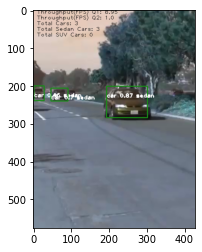

2


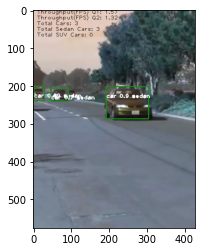

3


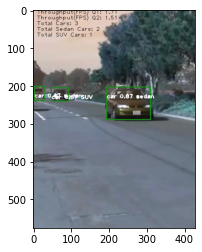

4


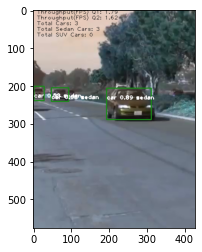

5


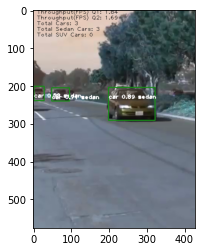

6


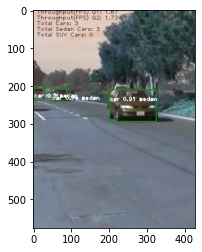

7


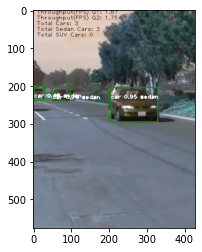

8


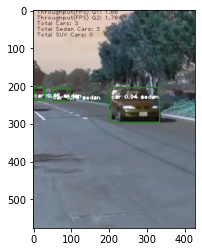

9


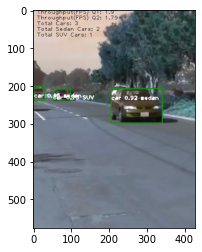

10


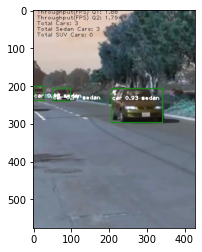

11


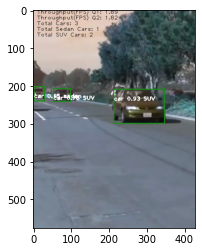

12


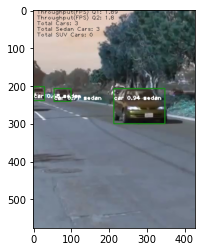

13


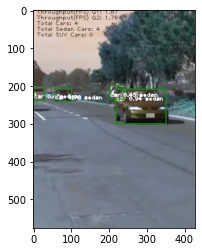

14


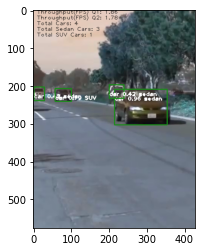

15


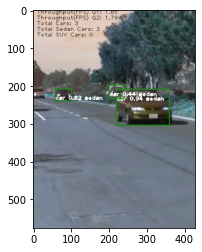

16


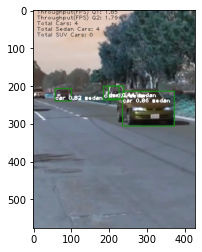

17


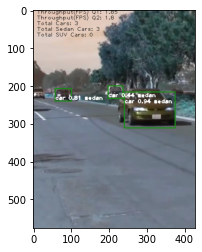

18


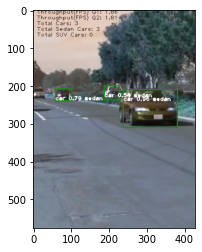

19


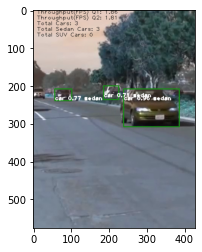

20


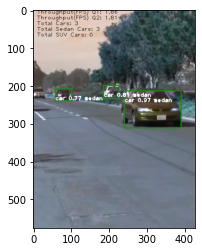

21


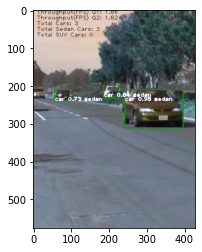

22


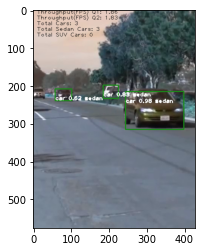

23


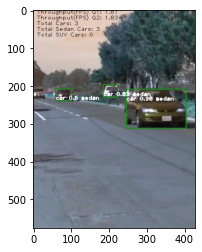

24


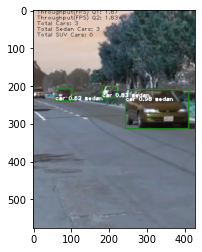

25


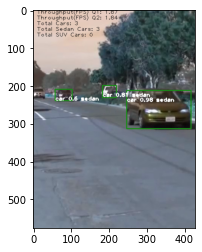

26


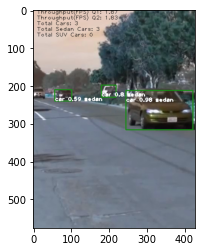

27


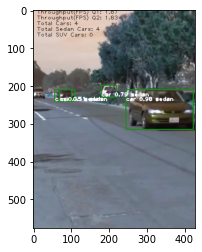

28


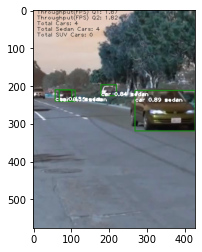

29


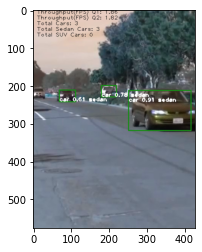

30


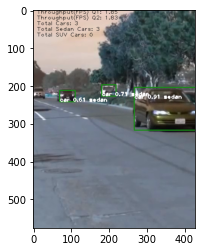

31


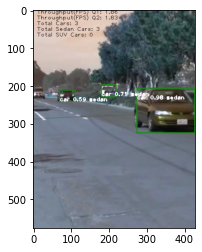

32


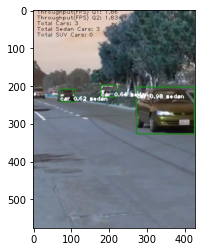

33


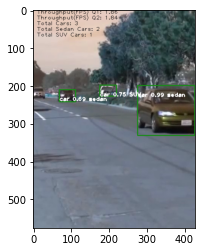

34


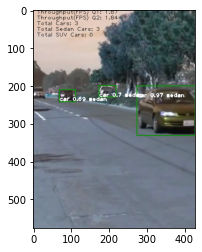

35


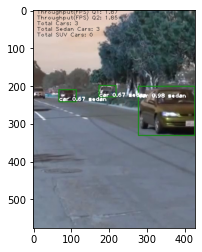

36


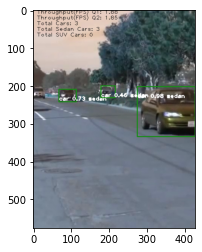

37


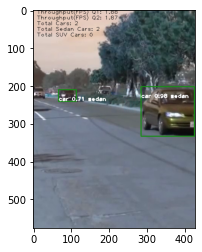

38


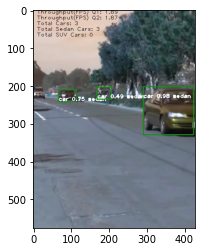

39


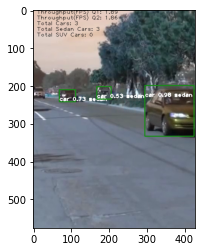

40


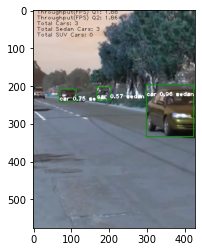

41


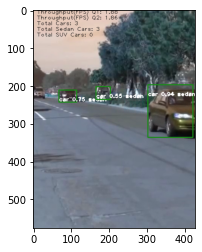

42


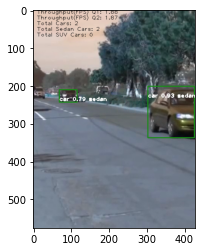

43


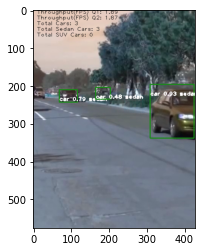

44


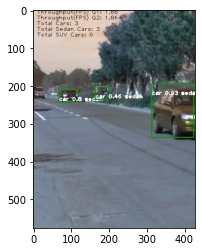

45


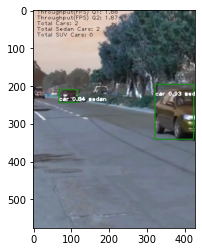

46


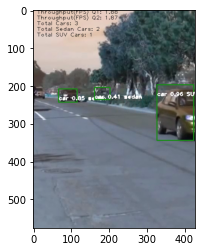

47


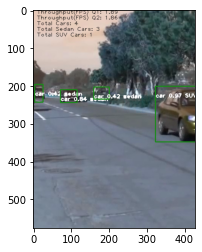

48


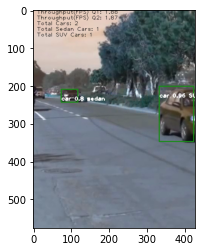

49


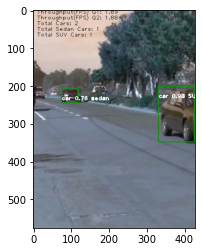

50


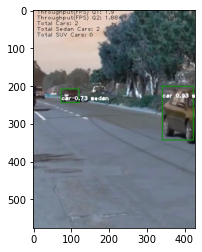

51


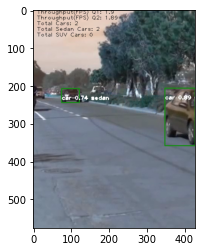

52


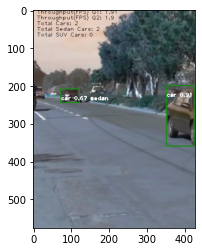

53


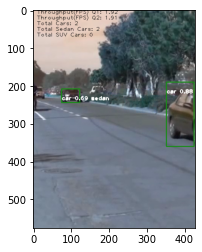

54


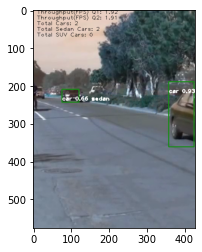

55


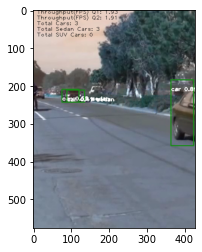

56


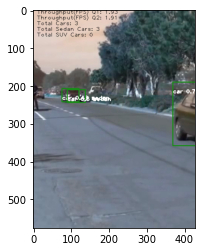

57


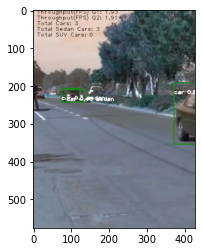

58


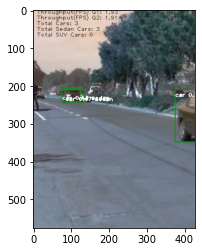

59


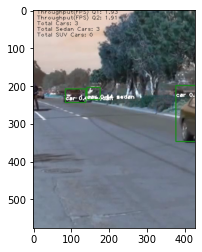

60


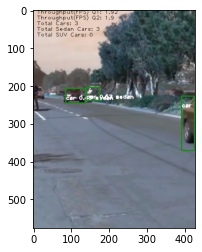

61


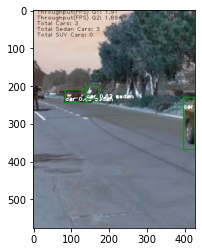

62


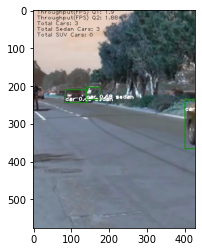

63


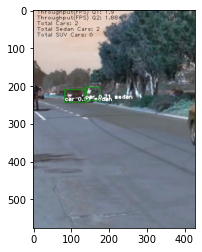

64


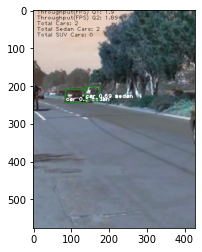

65


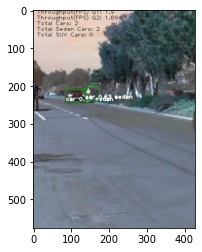

66


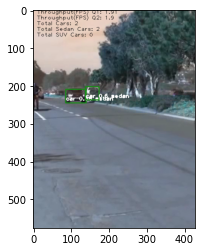

67


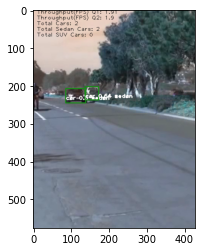

68


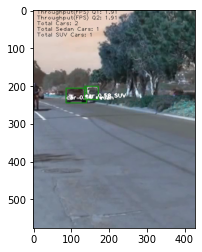

69


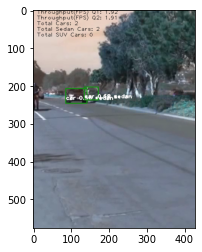

70


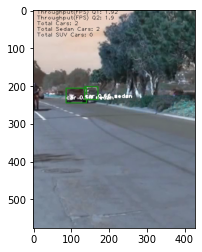

71


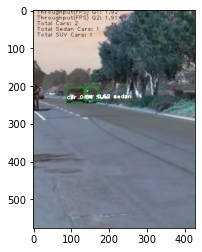

72


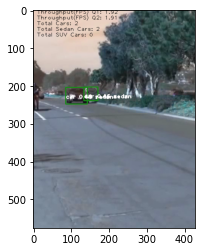

73


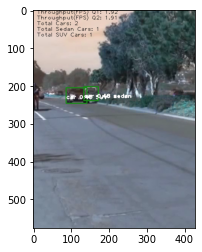

74


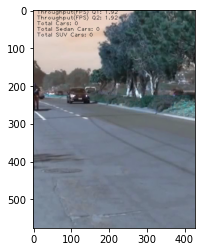

75


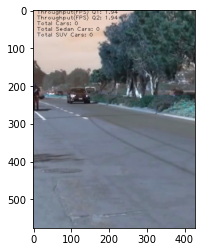

76


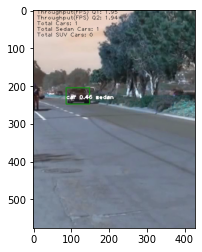

77


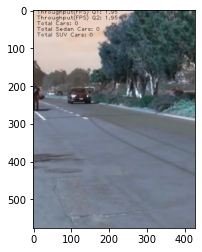

78


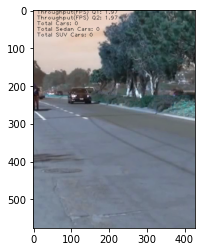

79


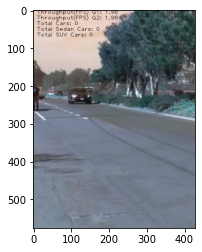

80


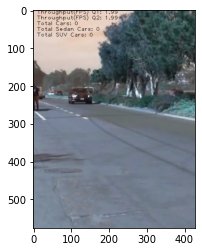

81


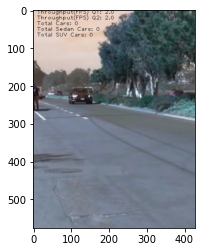

82


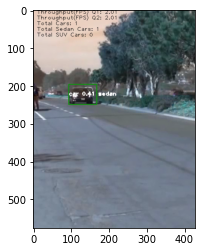

83


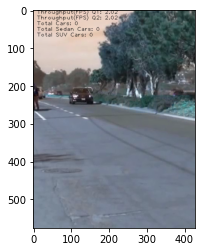

84


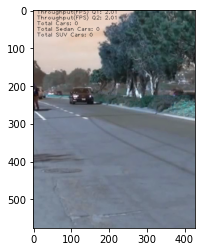

85


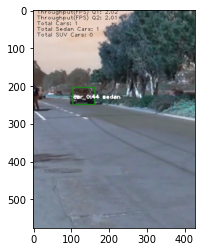

86


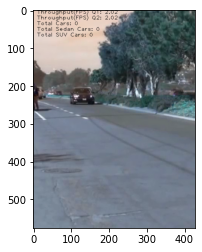

87


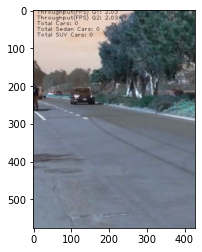

88


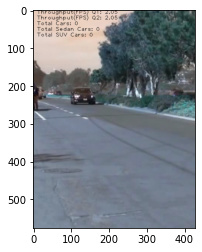

89


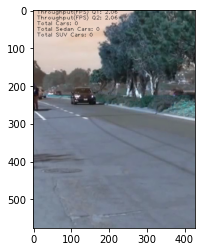

90


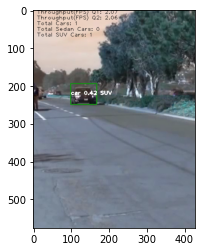

91


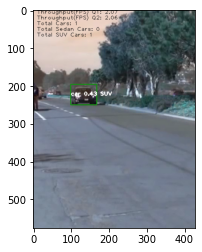

92


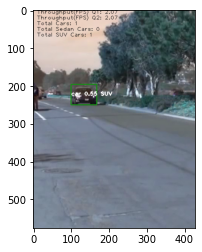

93


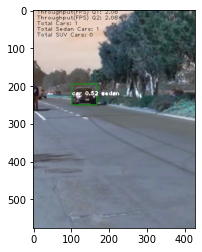

94


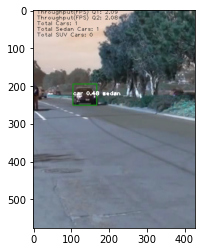

95


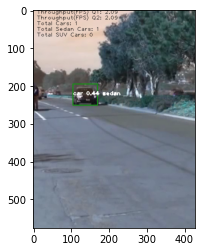

96


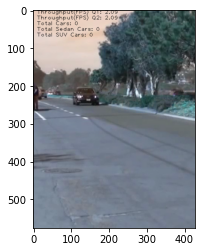

97


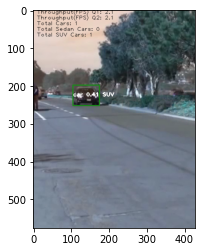

98


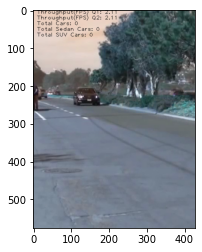

99


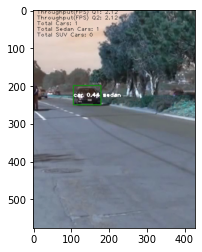

100


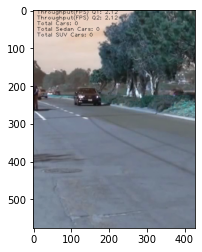

101


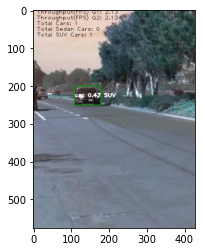

102


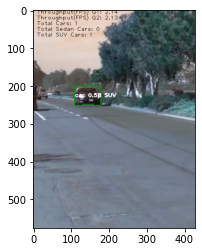

103


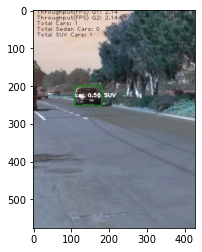

104


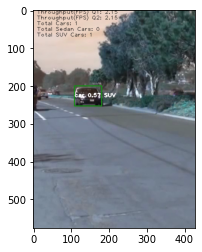

105


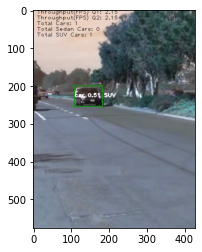

106


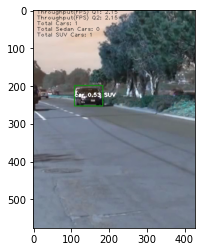

107


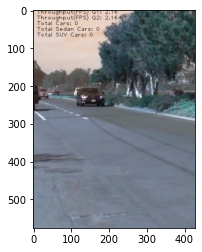

108


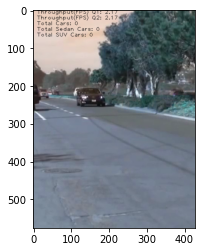

109


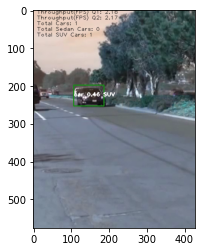

110


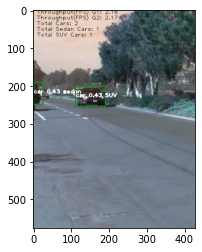

111


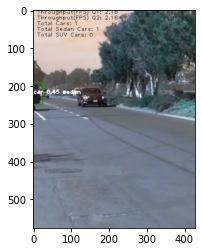

112


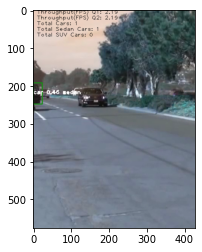

In [ ]:
#loading image
starting_time=time.time()
df = pd.DataFrame()
class_typ ={0:"sedan", 1:"SUV"}
cap=cv2.VideoCapture("assignment_clip.mp4")
font = cv2.FONT_HERSHEY_PLAIN
frame_id = 0
frame_id_lst = []
car_count = []
sedan_list,suv_list = [],[]

fps_list1=[]
fps_list2=[]
time_1=[]
time_2=[]

while (True and frame_id < 900):
    try:
      _,frame= cap.read() # 
      frame_id+=1
      print(frame_id)
      
      height,width,channels = frame.shape
      frame_id_lst.append(frame_id)
      #detecting objects
      blob = cv2.dnn.blobFromImage(frame,0.00392,(320,320),(0,0,0),True,crop=False) #reduce 416 to 320    

          
      net.setInput(blob)
      outs = net.forward(outputlayers)
      #print(outs[1])


      #Showing info on screen/ get confidence score of algorithm in detecting an object in blob
      class_ids=[]
      confidences=[]
      boxes=[]
      sedan_count,suv_count = 0,0
    
      for out in outs:
          for detection in out:
              scores = detection[5:]
              class_id = np.argmax(scores)
              confidence = scores[class_id]
              if (confidence > 0.3 and class_id==2):
                  #object detected
                  center_x= int(detection[0]*width)
                  center_y= int(detection[1]*height)
                  w = int(detection[2]*width)
                  h = int(detection[3]*height)

                  #cv2.circle(img,(center_x,center_y),10,(0,255,0),2)
                  #rectangle co-ordinaters
                  x=int(center_x - w/2)
                  y=int(center_y - h/2)
                  #cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
                  
                  boxes.append([x,y,w,h]) #put all rectangle areas
                  
                  confidences.append(float(confidence)) #how confidence was that object detected and show that percentage
                  class_ids.append(class_id) #name of the object tha was detected
                  #print(class_id)
      indexes = cv2.dnn.NMSBoxes(boxes,confidences,0.4,0.6)
      car_count.append(len(indexes))
      elapsed_time_1 = time.time() - starting_time
      fps_1=frame_id/elapsed_time_1
      fps_list1.append(fps_1)
      time_1.append(elapsed_time_1)
      
      try:
        for i in range(len(boxes)):
            if i in indexes:
                x,y,w,h = boxes[i]
                roi=frame[y:y+h,x:x+w]
                if roi.shape[1] != 0:
                  img=cv2.resize(roi,(224,224))/255
                  class_1=model_classifier.predict(np.array([img]))
                  class_arg=np.argmax(class_1)
                  label = str(classes[class_ids[i]])
                  if class_typ[class_arg] == 'sedan':
                    sedan_count+=1
                  elif class_typ[class_arg] == 'SUV':
                    suv_count+=1
                  else:
                    print("Error: Invalid car class")
                  confidence= confidences[i]
                  color = colors[class_ids[i]]
                  cv2.rectangle(frame,(x,y),(x+w,y+h),color,2)
                  cv2.putText(frame,label+" "+str(round(confidence,2))+' '+class_typ[class_arg],(x,y+30),font,1,(255,255,255),2)
                  #cv2_imshow(frame)
      except Exception as e :
        # print(e)
        pass
      
      elapsed_time_2 = time.time() - starting_time
      fps_2=frame_id/elapsed_time_2
      fps_list2.append(fps_2)
      time_2.append(elapsed_time_2)
      sedan_list.append(sedan_count)  
      suv_list.append(suv_count) 
      cv2.putText(frame,"Throughput(FPS) Q1: "+str(round(fps_1,2)),(10,10),font,1,(0,0,0),1)
      cv2.putText(frame,"Throughput(FPS) Q2: "+str(round(fps_2,2)),(10,25),font,1,(0,0,0),1)
      cv2.putText(frame,"Total Cars: "+str(len(indexes)),(10,40),font,1,(0,0,0),1)
      cv2.putText(frame,"Total Sedan Cars: "+str(sedan_count),(10,55),font,1,(0,0,0),1)
      cv2.putText(frame,"Total SUV Cars: "+str(suv_count),(10,70),font,1,(0,0,0),1)
      
      pyplot.imshow(frame)
      pyplot.show()
      key = cv2.waitKey(1) #wait 1ms the loop will start again and we will process the next frame
      
      if key == 27: #esc key stops the process
          break;

    except AttributeError:
      print('error')
      break

print("Successful")
cap.release()    
cv2.destroyAllWindows()
end = time.time()
print(end - starting_time)



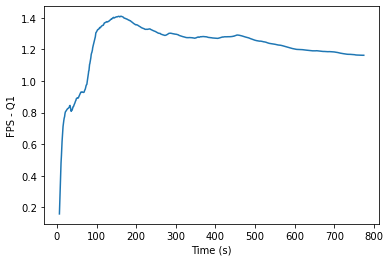

In [17]:
## Plotting FPS for Q1
pyplot.figure()
pyplot.plot(time_1, fps_list1)
pyplot.xlabel('Time (s)')
pyplot.ylabel('FPS - Q1')
pyplot.show()

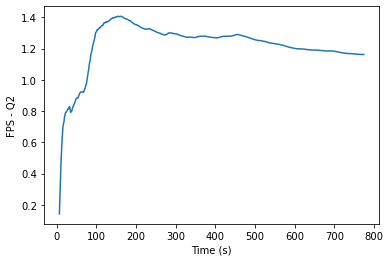

In [18]:
## Plotting FPS for Q2
pyplot.figure()
pyplot.plot(time_2, fps_list2)
pyplot.xlabel('Time (s)')
pyplot.ylabel('FPS - Q2')
pyplot.show()